# Machine Learning Exercise 15

# Dimensionality Reduction - MNIST 



##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
%tensorflow_version 2.x

import numpy as np
import tensorflow as tf

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2
Found GPU at: /device:GPU:0


## Load data

Load training data from Tensorflow Keras library




In [ ]:
def load_data():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()
    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    ntest = Xtest.shape[0]
    num_classes = max(Ytrain) + 1
    print("Training input %s" %str(Xtrain.shape))
    print("Training output %s" %str(Ytrain.shape))
    print("Test input %s" %str(Xtest.shape))
    print("Test output %s" %str(Ytest.shape))
    print("Input shape: %s" %str(input_shape))
    print("Number of classes: %d" %num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    # reshape input in 4D array
    Xtrain = Xtrain.reshape(ninput,imgsize[0],imgsize[1],1)
    Xtest = Xtest.reshape(ntest,imgsize[0],imgsize[1],1)
    
    # Transform output to one-out-of-n encoding
    Ytrain = tf.keras.utils.to_categorical(Ytrain, num_classes)
    Ytest = tf.keras.utils.to_categorical(Ytest, num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]
  

[Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes] = load_data()

11490434/11490434 [==============================] - 0s 0us/step
Training input (60000, 28, 28)
Training output (60000,)
Test input (10000, 28, 28)
Test output (10000,)
Input shape: (28, 28, 1)
Number of classes: 10


## Show random image



0


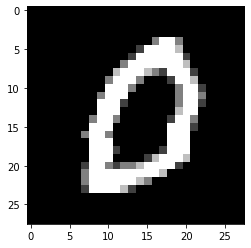

In [ ]:
import matplotlib.pyplot as plt
import random

i = random.randrange(0,Xtrain.shape[0])
image = Xtrain[i]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))

label = Ytrain[i].argmax()  # categorical from one-hot-encoding
print(label)

plt.imshow(pixels, cmap='gray')
plt.show()


##PCA 

In [ ]:
# flatten the data
Xtrain_flatten = Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1] * Xtrain.shape[2] * Xtrain.shape[3]))
Xtest_flatten = Xtest.reshape((Xtest.shape[0], Xtest.shape[1] * Xtest.shape[2] * Xtest.shape[3]))

print("The flatten shape of training data is (%s, %s)" % (Xtrain_flatten.shape[0], Xtrain_flatten.shape[1]))
print("The flatten shape of testing data is (%s, %s)" % (Xtest_flatten.shape[0], Xtest_flatten.shape[1]))

The flatten shape of training data is (60000, 784)
The flatten shape of testing data is (10000, 784)


In [ ]:
from sklearn.decomposition import PCA

# select the number of components for the PCA projection
n_components = 200

# execute PCA
pca = PCA(n_components = n_components)
Xtrain_pca = pca.fit_transform(Xtrain_flatten)
print("The shape of pca training data is (%s, %s)" % (Xtrain_pca.shape[0], Xtrain_pca.shape[1]))

The shape of pca training data is (60000, 200)


Check the forward and backward transformation 

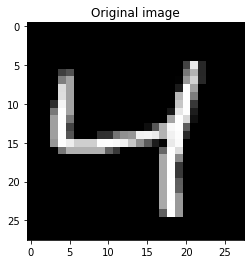

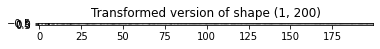

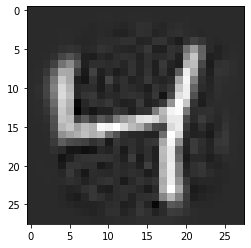

In [ ]:
# show the transformation forward and backwards
idx = 2

# original image
img_plot = np.array(Xtrain[idx], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Original image")

# transformed low dimensional representation
img_plot = np.array(Xtrain_pca[idx,:], dtype="float")
img_plot = img_plot.reshape((1,n_components))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Transformed version of shape {}".format(img_plot.shape))

# reconstructed image
img_plot = pca.inverse_transform(Xtrain_pca[idx,:])
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')


Plot the 2D or 3D components

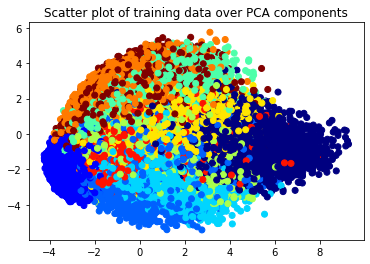

In [ ]:
# select the number of components for the PCA projection
n_components = 2

# execute PCA
pca = PCA(n_components = n_components)
Xtrain_pca = pca.fit_transform(Xtrain_flatten)

Ytrain_plot = np.argmax(Ytrain,axis=1)
Ytest_plot = np.argmax(Ytest,axis=1)

if n_components == 2:
  plt.figure()
  plt.title("Scatter plot of training data over PCA components")
  plt.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], c=Ytrain_plot, cmap='jet')

elif n_components == 3:
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = Axes3D(fig)
  plt.title("Scatter plot of PCA components")
  ax.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], Xtrain_pca[:,2], c=Ytrain_plot, cmap='jet')
  plt.show()

else:
  print("For a scatter plot use 2 or 3 principal components")

##Deep Autoencoder


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

def DeepAutoencoder(input_shape, out_shape):
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu', name="dense1"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu', name="dense2"))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='relu', name="dense3"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='relu', name="dense4"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu', name="dense5"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu', name="dense6"))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(out_shape, activation='relu', name="denseout"))

    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=optimizer)
    
    return model
 
# create the model
input_shape = Xtrain_flatten.shape[1:]
out_shape = Xtrain_flatten.shape[1]
deep_ae = DeepAutoencoder(input_shape, out_shape)
deep_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense1 (Dense)              (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense2 (Dense)              (None, 150)               4

In [ ]:
epochs = 30
history = deep_ae.fit(Xtrain_flatten, Xtrain_flatten, batch_size=256, epochs=epochs, validation_data=(Xtest_flatten, Xtest_flatten), 
                      verbose=1)

Epoch 1/30
235/235 [==============================] - 6s 11ms/step - loss: 0.0906 - val_loss: 0.0660
Epoch 2/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0640 - val_loss: 0.0587
Epoch 3/30
235/235 [==============================] - 3s 11ms/step - loss: 0.0602 - val_loss: 0.0556
Epoch 4/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 5/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0578 - val_loss: 0.0532
Epoch 6/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0571 - val_loss: 0.0523
Epoch 7/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0567 - val_loss: 0.0528
Epoch 8/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0559 - val_loss: 0.0514
Epoch 9/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0554 - val_loss: 0.0511
Epoch 10/30
235/235 [==============================] - 2s 9ms/step - loss: 0.0552 - val_loss: 0.04

Check the Deep Autoencoder reconstruction over test images

313/313 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Deep Autoencoder reconstruction')

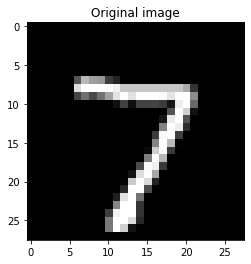

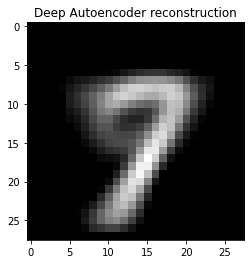

In [ ]:
# show the encoder-decoder reconstruction
idx = 0

# original image
img_plot = np.array(Xtest_flatten[idx, :], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Original image")

Xtest_flatten_pred = deep_ae.predict(Xtest_flatten)

img_plot = np.array(Xtest_flatten_pred[idx,:], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Deep Autoencoder reconstruction")

In [ ]:
from tensorflow.keras.models import Model

def layer_extractor(model, layer_name):
    
    # define the input tensor
    original_input = model.get_layer(index=0).input

    # define the output tensor
    output_layer = model.get_layer(name=layer_name).output
    
    # compile the model
    extractor = Model(inputs=original_input, outputs=output_layer)
    optimizer = 'adam' #alternative 'SGD'
    extractor.compile(loss=tf.keras.losses.mean_squared_error, optimizer=optimizer)

    return extractor

# dense3 is the bottleneck layer (you can extract the output from any layer)
layer_name = "dense3"
encoder = layer_extractor(deep_ae, layer_name)

1875/1875 [==============================] - 4s 2ms/step


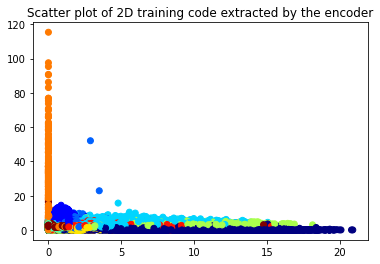

In [ ]:
# predict the training data to check if the encoder is better than PCA
encoder_predictions = encoder.predict(Xtrain_flatten)

plt.figure()
plt.title("Scatter plot of 2D training code extracted by the encoder")
plt.scatter(encoder_predictions[:,0], encoder_predictions[:,1], c=Ytrain_plot, cmap='jet')

##Convolutional Variational Autoencoder

VAE class

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Lambda, Reshape
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

class VAE():
    def __init__(self, input_shape, z_dim=2, n_layers=4, base_filters=32, kernel_size=3, kl_weight=10**(-3)):
        self.input_shape = input_shape
        self.z_dim = z_dim
        self.n_layers = n_layers
        self.base_filters = base_filters
        self.kernel_size = kernel_size
        self.kl_weight = kl_weight

        self.enc = self.define_encoder()
        self.dec = self.define_decoder()
        self.vae = self.define_vae()
        
    def get_batch(self, images, n_samples):
      # choose random instances
      idx = np.random.randint(0, images.shape[0], n_samples)
      # select images
      X = images[idx]
      return X

    def define_encoder(self):
        # set inputs
        x_input = Input(shape=self.input_shape, name="enc_inp")
        image_size = self.input_shape[0]
        
        filters = self.base_filters
        # conv feature extractor
        for i in range(self.n_layers):
            if i == 0:
                x = Conv2D(filters=self.base_filters,
                   kernel_size = self.kernel_size,
                   activation="relu",
                   strides=2,
                   padding="same")(x_input)
            else:
                x = Conv2D(filters=filters,
                   kernel_size = self.kernel_size,
                   activation="relu",
                   strides=2,
                   padding="same")(x)
            filters *= 2
        
        x = Flatten()(x)
        dim = x.shape[-1]
        x_out = Dense(dim // 2, activation="relu")(x)
        
        # compute means and variances
        z_mean = Dense(self.z_dim, name="mean")(x)
        z_log_var = Dense(self.z_dim, name="log_var")(x)
        
        def sampling(args):
            z_mean, z_log_var = args
            batch_size = tf.shape(z_mean)[0]
            z_dim = z_mean.shape[1]
            eps = K.random_normal(shape=(batch_size, z_dim), mean=0.0, stddev=1.0)
            return z_mean + K.exp(z_log_var / 2.0) * eps
        
        # sample z from latent space
        z = Lambda(sampling, output_shape=(self.z_dim,))([z_mean, z_log_var])
        
        encoder = Model(x_input, [z_mean, z_log_var, z], name="vae_encoder")
        return encoder


    def define_decoder(self):
        # set inputs
        latent_input = Input(shape=(self.z_dim,), name="z")
        
        # compute feture maps dimensions for symmetric decoder (assuming strides=2)
        starting_filters = self.base_filters * self.n_layers
        feture_map_size = self.input_shape[0] // 2**(self.n_layers)
        
        # reshape into feature maps
        x = Dense(feture_map_size * feture_map_size * starting_filters)(latent_input)
        x = Reshape((feture_map_size, feture_map_size, starting_filters))(x)
        
        filters = starting_filters
        # conv upsampling
        for i in range(self.n_layers-1):
            filters //= 2
            x = Conv2DTranspose(filters=filters,
                   kernel_size = self.kernel_size,
                   activation="relu",
                   strides=2,
                   padding="same")(x)
            
        # output con layer
        output = Conv2DTranspose(filters=self.input_shape[-1],
                   kernel_size = self.kernel_size,
                   activation="sigmoid",
                   strides=2,
                   padding="same")(x)
        
        decoder = Model(latent_input, output, name="vae_decoder")
        return decoder


    def define_vae(self):
        # set inputs to cvae
        x_vae = Input(shape=self.input_shape)        
        
        # get encoder output
        z_mean, z_log_var, z = self.enc(x_vae)
                
        # get decoder output
        decoder_output = self.dec(z)
        
        cvae = Model(x_vae, decoder_output, name="vae_model")
        return cvae

    @tf.function
    def get_loss(self, inputs, targets):
        # predict output
        z_mean, z_log_var, z = self.enc(inputs)
        preds = self.dec(z)
        # compute contributions
        recon = BinaryCrossentropy()(targets, preds)
        kl = 0.5 * tf.reduce_mean(tf.reduce_sum(tf.square(z_mean) + tf.exp(z_log_var) - z_log_var - 1, axis = -1))
        out = recon + self.kl_weight * kl 
        return out
    
    @tf.function
    def train_step(self, inputs, targets, optimizer):
        with tf.GradientTape() as tape:
            loss_value = self.get_loss(inputs, targets)
        grads = tape.gradient(loss_value, self.vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.vae.trainable_variables))
        return loss_value


    def train_vae(self, images, epochs, batch_size, path_save_imgs=None, images_test=None):
        bat_per_epo = int(images.shape[0] / batch_size)
        vae_loss = tf.keras.metrics.Mean()
        optimizer = Adam()
        step = 4
        save_imgs_ep = np.arange(0,epochs,step)
        print("Start training VAE\n")
        # manually enumerate epochs
        for i in range(epochs):
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # get randomly selected 'real' samples
                img_batch = self.get_batch(images, batch_size)
                # train vae
                model_lss = self.train_step(img_batch, img_batch, optimizer)
                vae_loss(model_lss)
            
            # summarize loss on epoch
            print("Epoch {:03d}: train_loss: {:.3f}".format(i + 1, vae_loss.result()))
            
            # evaluate model on testing data
            if (images_test != None):
                test_loss = self.vae.evaluate(images_test, images_test, batch_size=batch_size)
                print("Epoch {:03d}: test_loss: {:.3f}".format(i + 1, test_loss))

In [ ]:
# Params
z_dim = 2
n_layers = 2 #keep 2 layers for spatial dimension consistency
base_filters = 32
kernel_size = 3
epochs = 50
batch_size=32
kl_weight = 1.0 * 10**(-3) #weight of the KL divergence in the VAE loss

# instantiate VAE class
model = VAE(Xtrain.shape[1:],
             z_dim=z_dim,
             base_filters=base_filters,
             kernel_size=kernel_size,
             n_layers=n_layers,
             kl_weight=kl_weight)

# enc summary
model.enc.summary()
# decoder summary
model.dec.summary()
# vae summary
model.vae.summary()

Model: "vae_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_inp (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['enc_inp[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                        

Train VAE

In [ ]:
# train model
model.train_vae(Xtrain, epochs, batch_size)

Start training VAE

Epoch 001: train_loss: 0.239
Epoch 002: train_loss: 0.227
Epoch 003: train_loss: 0.221
Epoch 004: train_loss: 0.217
Epoch 005: train_loss: 0.214
Epoch 006: train_loss: 0.212
Epoch 007: train_loss: 0.211
Epoch 008: train_loss: 0.209
Epoch 009: train_loss: 0.208
Epoch 010: train_loss: 0.207
Epoch 011: train_loss: 0.206
Epoch 012: train_loss: 0.206
Epoch 013: train_loss: 0.205
Epoch 014: train_loss: 0.205
Epoch 015: train_loss: 0.204
Epoch 016: train_loss: 0.204
Epoch 017: train_loss: 0.203
Epoch 018: train_loss: 0.203
Epoch 019: train_loss: 0.203
Epoch 020: train_loss: 0.202
Epoch 021: train_loss: 0.202
Epoch 022: train_loss: 0.202
Epoch 023: train_loss: 0.201
Epoch 024: train_loss: 0.201
Epoch 025: train_loss: 0.201
Epoch 026: train_loss: 0.201
Epoch 027: train_loss: 0.201
Epoch 028: train_loss: 0.200
Epoch 029: train_loss: 0.200
Epoch 030: train_loss: 0.200
Epoch 031: train_loss: 0.200
Epoch 032: train_loss: 0.200
Epoch 033: train_loss: 0.199
Epoch 034: train_loss: 

Visualize latent space and reconstructions 

313/313 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'VAE reconstruction')

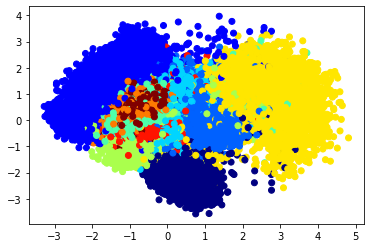

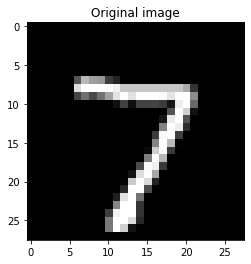

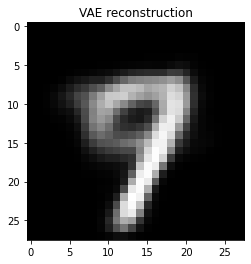

In [ ]:
# %% Check latent space for testing samples and VAE (assuming z_dim=2)

z_m_train, z_lv_train, z_train = model.enc.predict(Xtrain, batch_size)
plt.figure()
plt.scatter(z_m_train[:,0], z_m_train[:,1], c=np.argmax(Ytrain,-1), cmap='jet')


# show the encoder-decoder reconstruction
idx = 0

# original image
img_plot = np.array(Xtest[idx, :], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("Original image")

Xtest_pred = model.vae.predict(Xtest)

img_plot = np.array(Xtest_pred[idx,:], dtype="float")
img_plot = img_plot.reshape((28,28))
plt.figure()
plt.imshow(img_plot, cmap='gray')
plt.title("VAE reconstruction")


Sample the learnt latent distribution and visualize generated samples

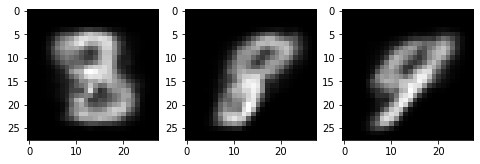

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate class labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]


n_samples = 3
z_input, _ = generate_latent_points(z_dim, n_samples, num_classes)
fi = model.dec(z_input)

f, ax = plt.subplots(1,3, figsize=(8,6))
ax[0].imshow(fi[0,:,:,0], cmap="gray")
ax[1].imshow(fi[1,:,:,0], cmap="gray")
ax[2].imshow(fi[2,:,:,0], cmap="gray")

## Evaluate low dimensional (2D) transformation with classification task

Overall accuracy, precision, recall and F-score 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# train the model using the VAE predictions (samples x latent_space) training sets
knn_model = KNeighborsClassifier(n_neighbors=200)
vae_predictions, _, _ = model.enc.predict(Xtrain)
knn_model.fit(vae_predictions, Ytrain_plot)

test_vae_predictions, _, _ =  model.enc(Xtest)
knn_pred_vae = knn_model.predict(test_vae_predictions)

accuracy_knn_encoder = accuracy_score(Ytest_plot, knn_pred_vae)
print("Accuracy obtained with KNN + 2D features extracted from Conv VAE: %s" %accuracy_knn_encoder)

# train the model using the encoder predictions (samples x features) training sets
knn_model = KNeighborsClassifier(n_neighbors=200)
knn_model.fit(encoder_predictions, Ytrain_plot)

test_encoder_features =  encoder.predict(Xtest_flatten)
knn_pred_encoder = knn_model.predict(test_encoder_features)

accuracy_knn_encoder = accuracy_score(Ytest_plot, knn_pred_encoder)
print("Accuracy obtained with KNN + 2D features extracted from Deep Autoencoder: %s" %accuracy_knn_encoder)

# train the knn model with pca 2D features
pca = PCA(n_components = 2)
train_pca_features = pca.fit_transform(Xtrain_flatten)

knn_model = KNeighborsClassifier(n_neighbors=200)
knn_model.fit(train_pca_features, Ytrain_plot)

test_pca_features = pca.transform(Xtest_flatten)
knn_pred_pca = knn_model.predict(test_pca_features)

accuracy_knn_pca = accuracy_score(Ytest_plot, knn_pred_pca)
print("Accuracy obtained with KNN + 2D features extracted from PCA: %s" %accuracy_knn_pca)


1875/1875 [==============================] - 3s 2ms/step
Accuracy obtained with KNN + 2D features extracted from Conv VAE: 0.6564
313/313 [==============================] - 1s 2ms/step
Accuracy obtained with KNN + 2D features extracted from Deep Autoencoder: 0.7248
Accuracy obtained with KNN + 2D features extracted from PCA: 0.4789
